# Purpose

A project demonstrating anomaly detection using a Gaussian model in Python. Now to load the required libraries and data.

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline


df = loadmat("C:\\Users\\CoreySSD\\Downloads\\ex8data1.mat")

X = df["X"]
Xval = df["Xval"]
yval = df["yval"]

It's always a good start to get familiar with the data. Let's visualize it.

Text(0.5,1,'Latency by Throughput')

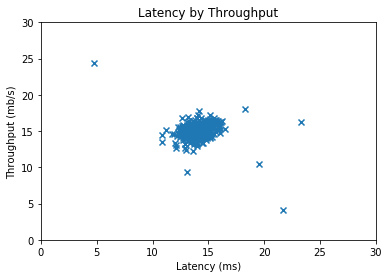

In [2]:
plt.scatter(X[:,0],X[:,1],marker="x")

plt.xlim(0,30)
plt.ylim(0,30)

plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title("Latency by Throughput")

Most of the data is focused $\approx$ (14, 14). Next, need to estimate the mean and variance for the Gaussian model.

In [3]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data
    """
    
    # Compute mean
    mu = np.mean(X, axis= 0)
    
    # Compute variance
    var = np.var(X, axis= 0)
    
    return mu,var

mu, sigma2 = estimateGaussian(X)

print(f"\n The average and variance for Latency (ms) is {mu[0]: 0.3f}, and {sigma2[0]: 0.3f} \n",
     f"The average and variance for Latency (ms) is {mu[1]: 0.3f}, and {sigma2[1]: 0.3f}")


 The average and variance for Latency (ms) is  14.112, and  1.833 
 The average and variance for Latency (ms) is  14.998, and  1.710


Now that the mean and variance is found for each feature, the probability of each value can be estimated. This will provide the probability density of the data. I will use the Multivariate Gaussian Distribution to estimate this.

In [4]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution
    """
    
    k = len(mu)
    
    sigma2 = np.diag(sigma2)
    
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

p = multivariateGaussian(X, mu, sigma2)

Text(0.5,1,'Latency by Throughput with Probability Contours')

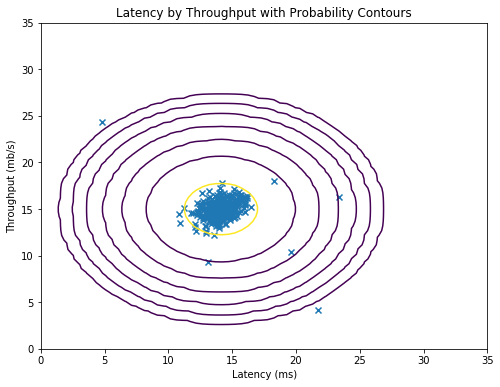

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x")

X1,X2 = np.meshgrid(np.linspace(0,35,num=70),np.linspace(0,35,num=70))
p2 = multivariateGaussian(np.hstack((X1.flatten()[:,np.newaxis],X2.flatten()[:,np.newaxis])), mu, sigma2)

contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)]).T
plt.contour(X1,X2,p2[:,np.newaxis].reshape(X1.shape),contour_level)

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title("Latency by Throughput with Probability Contours")

As noted before, most of the data is within the yellow center $\approx$ (14, 14) on the graph. Next step is to derive a threshold which will flag cases that are anomalies. An algorithm can wrote to calculate the best threshold given the data. I usually like to use the F1-score as the evaluation metric since it encompases precision and recall in it's calculation.

In [6]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    
    best_epi = 0
    best_F1 = 0
    
    stepsize = (max(pval) - min(pval)) / 1000
    epi_range = np.arange(pval.min(), pval.max(), stepsize)
    
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        
        # Compute evaluation metrics of: precision, recall, and F1
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 =F1
            best_epi = epi
        
    return best_epi, best_F1

pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print(f"\n Best F1-score achieved was {F1: 0.3f} with the epsilon value being {epsilon}")


 Best F1-score achieved was  0.875 with the epsilon value being 8.990852779269496e-05


C:\Users\CoreySSD\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


Now that a good threshold has been identified, it's time to apply it to the data and produce a graph that highlights the anomalies.

Text(0.5,1,'Latency by Throughput with Probability Contours and Anomaly Highlights')

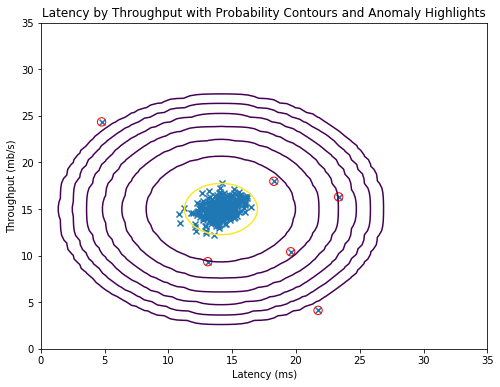

In [7]:
# Plotting data
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], marker="x")

# Plotting contour mesh
X1,X2 = np.meshgrid(np.linspace(0, 35, num=70), np.linspace(0, 35, num=70))
p2 = multivariateGaussian(np.hstack((X1.flatten()[:,np.newaxis], X2.flatten()[:,np.newaxis])), mu, sigma2)
contour_level = 10**np.array([np.arange(-20, 0, 3, dtype=np.float)]).T
plt.contour(X1, X2, p2[:, np.newaxis].reshape(X1.shape),contour_level)


# Circling of anomalies
outliers = np.nonzero(p < epsilon)[0]
plt.scatter(X[outliers, 0],X[outliers, 1], marker ="o", facecolor="none", edgecolor="r", s=70)
plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title("Latency by Throughput with Probability Contours and Anomaly Highlights")

This was just a demonstration of how to identify anomalies using the Gaussian distribution. Putting this into production would be straigh simple. The cases that get flagged would get pulled and sent to whomever for further pursuit.